# 过拟合的限制方法——dropout

当一个复杂的前馈神经网络被训练在小的数据集时，容易造成过拟合。

Dropout可以作为训练深度神经网络的一种trick供选择。在每个训练批次中，通过忽略一半的特征检测器（让一半的隐层节点值为0），可以明显地减少过拟合现象。这种方式可以减少特征检测器（隐层节点）间的相互作用，检测器相互作用是指某些检测器依赖其他检测器才能发挥作用。

Dropout说的简单一点就是：我们在前向传播的时候，让某个神经元的激活值以一定的概率p停止工作，这样可以使模型泛化性更强，因为它不会太依赖某些局部的特征，如图1所示。

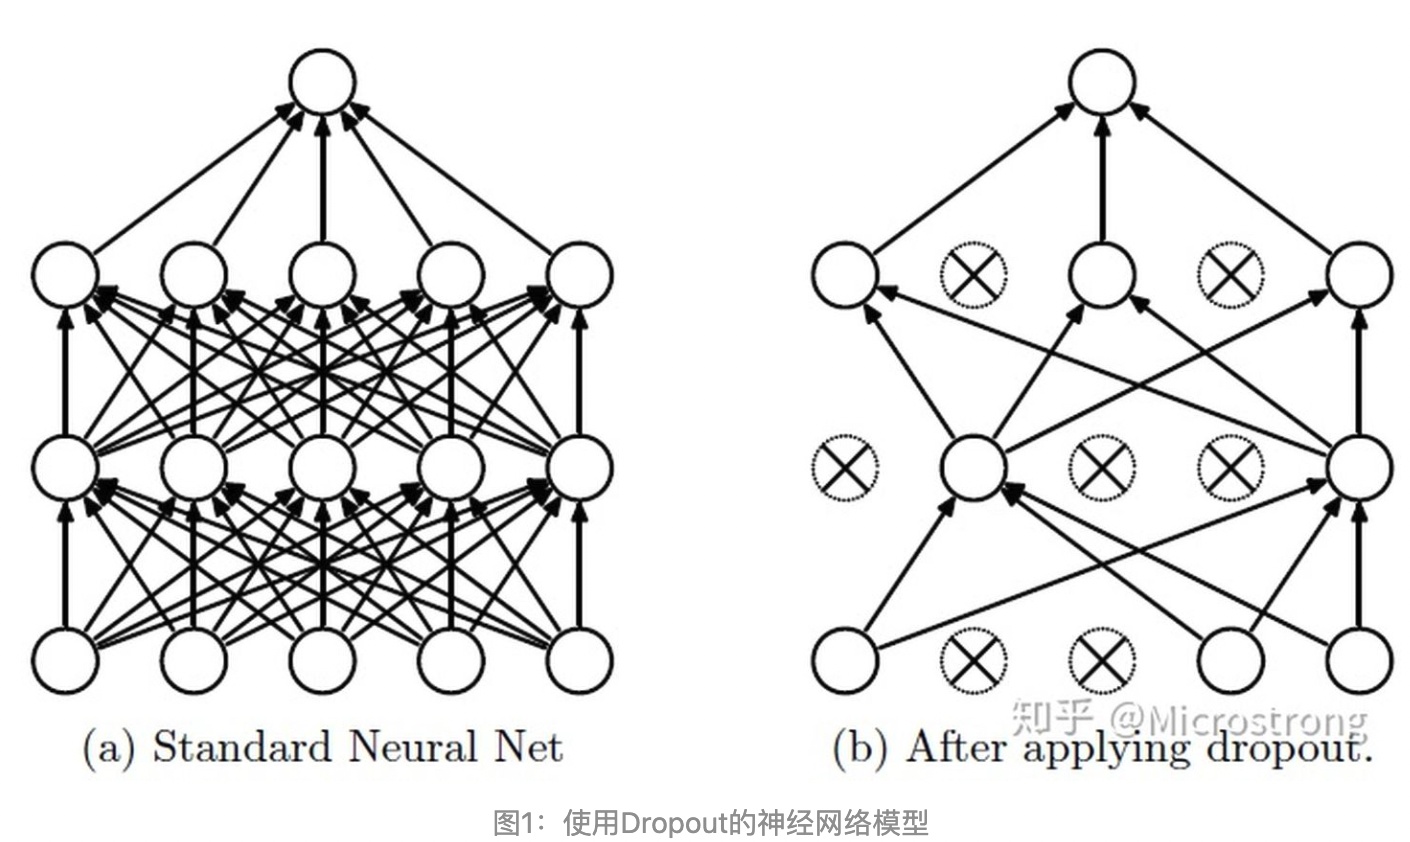

In [1]:
import torch
import numpy as np
from torch import nn
from d2l import torch as d2l

In [3]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.randn(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [4]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  6.,  0.,  0., 12.,  0.],
        [16.,  0.,  0.,  0.,  0., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


## 定义模型参数

In [9]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

## 定义模型
下面的模型将dropout应用于每个隐藏层的输出（在激活函数之后）。我们可以分别为每一层设置丢弃概率。 一种常见的技巧是在**靠近输入层的地方**设置较低的丢弃概率。 下面，我们将第一个和第二个隐藏层的丢弃概率分别设置为0.2和0.5。我们确保dropout只在训练期间有效。

In [18]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

## 训练和测试

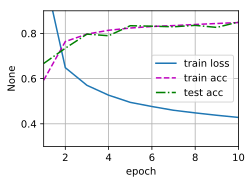

In [19]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 简洁实现

In [13]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

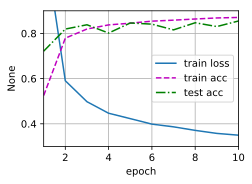

In [14]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)